In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn_with_lease_and_fee import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
def show_miner_accounting_charts(df):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(13.4, 4.8))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(df['day'], df['reward_earned'], label="Rewards")
    ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
    ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
    ax2.set_title("Miner cash flow")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def compare_configurations(cfgs, title, days, stats_interval=DAY):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(days, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.grid(axis='y', color='#EEE')
    for label, df in statss.items():
        plt.plot(df['day'], df['net_equity'], label=label)

    plt.plot()
    plt.title("Miner equity - " + title)
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

## Repay the shortfall

In [4]:
days = 3 * YEAR + 1
stats_interval = DAY

In [5]:
def run_sim(x):
    initial_pledge_projection_period_days = x[0]
    supply_lock_target = x[1]

    network = dataclasses.replace(MAINNET_APR_2023,
        token_lease_fee=0.20,
        reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
        initial_pledge_projection_period_days=initial_pledge_projection_period_days,
        supply_lock_target=supply_lock_target
    )

    miner_factory = BaseMinerState.factory(balance=0)
    cfg = SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=miner_factory,
    )
    stats = Simulator(cfg).run_all(days, stats_interval)
    return stats

In [6]:
x_in = np.array([20.0, 0.3])
stats_df = pd.DataFrame(data=run_sim(x_in))

<Figure size 640x480 with 0 Axes>

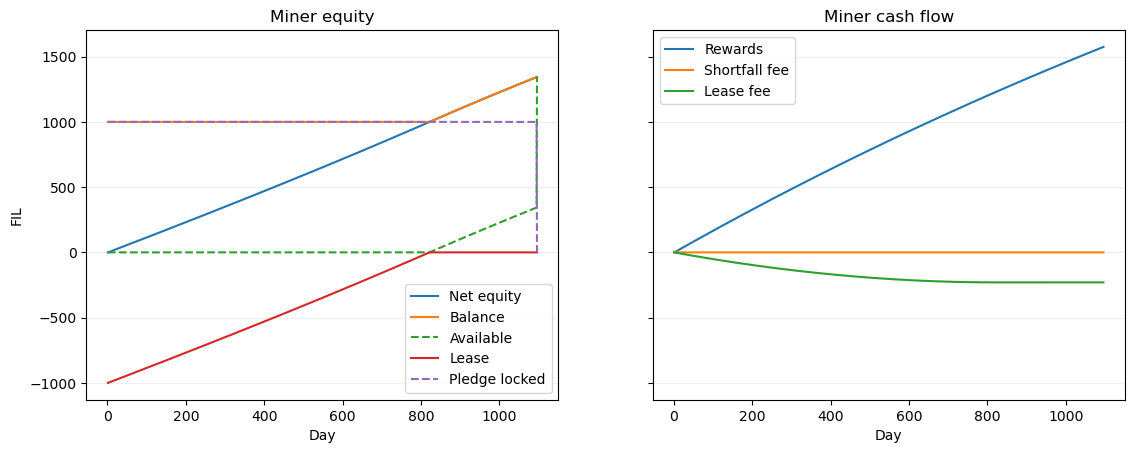

In [7]:
show_miner_accounting_charts(stats_df)

In [8]:
# Configurations limited by token availability.
network = dataclasses.replace(MAINNET_APR_2023,
    token_lease_fee=0.20,
    reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
    initial_pledge_projection_period_days=20.0,
    supply_lock_target=0.3
)
repay_miner_factory = RepayRatchetShortfallMinerState.factory(
    balance=0.,
    max_repayment_term=3. * YEAR,
    max_fee_reward_fraction=0.25,
    reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
)

compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by tokens', days)

RuntimeError: lock 1000.0 is less than minimum pledge 1000.0001220703125

In [ ]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE / EXBIBYTE, 3*YEAR, False),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE / EXBIBYTE, 3*YEAR, True),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by power', days)

## Burn the shortfall

In [ ]:
burn_miner_factory = BurnShortfallMinerState.factory(balance=0, max_shortfall_fraction=0.33, shortfall_pct_pow=0.75)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
    miner_factory=burn_miner_factory,
)
stats = Simulator(cfg).run_all(days, stats_interval)
burn_shortfall_df = pd.DataFrame(data=stats)
burn_shortfall_df


In [ ]:
show_miner_accounting_charts(burn_shortfall_df)

In [ ]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, False),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by tokens', days)


In [ ]:
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE / EXBIBYTE, 3 * YEAR, False),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE / EXBIBYTE, 3 * YEAR, True),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by power', days)
